# EXAMEN 2

Cada error u omisión en un ejercicio resta 0.5 puntos.

Cada código demás (que no se ha pedido) se interpretará como que no se está seguro de lo que se pide y resta 0.25 puntos.

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import ultralytics 

from ultralytics import YOLO
from PIL import Image
from ultralytics.solutions.solutions import BaseSolution
from ultralytics.utils.plotting import Annotator, colors
from datetime import datetime
import torch
import numpy as np

%matplotlib inline

from sklearn.model_selection import train_test_split


In [60]:
import tensorflow as tf
import tensorflow_datasets as tfds
tf.config.set_visible_devices([], 'GPU')


/home/iabd/miniconda3/envs/iabd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EJERCICIO 1

El conjunto de datos cats_vs_dogs https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=es-419 es un conjunto de imágenes de perros y gatos.

Tienes que entrenar un modelo de redes convolucionales para que aprenda a clasificar entre perro y gato, pero no vamos a empezar de cero, vamos a usar alguna de las redes ya existentes: InceptionV3.

Tienes que seguir los siguientes pasos:
* Carga el conjunto de imágenes (entrenamiento, validación y pruebas)
* Explora los datos: número de elementos, número de clases, nombres de las clases y dibuja algunas imágenes con sus etiquetas...
* Prepara los datos: añade más elementos al conjunto de entrenamiento (rotando, trasladando... las imágenes actuales) y prepara los datos para el modelo.
* Entrena un modelo para estos datos usando InceptionV3 y muestra todas las capas del modelo.
* Busca una imagen en Internet y haz una predicción.

Puedes usar take(10) a la hora de entrenar aunque los resultados sean malísimos, con el fin de que no pierdas tiempo. Usa pocos epoch y añade como comentarios que valores pondrías realmente.

In [142]:
# Definir parámetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
# Esto lo hago para intentar solucionar el problema que me da de imagenes corruptas,si no lo haria asi 
# dataset, info = tfds.load("cats_vs_dogs",split=["train[:80%]", "train[80%:90%]", "train[90%:]"], as_supervised=True, with_info=True)

DATASET_DIR = "/home/iabd/Escritorio/SAPA/SAPA/Examen2/Gatosyperros/PetImages"

# Cargar el dataset completo desde el directorio
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 8005 files belonging to 2 classes.


In [143]:

# Dividir el dataset en entrenamiento, validación y prueba
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))

# lo que pondría
#train_dataset = dataset.take(train_size)
# Para no perder tiempo
train_dataset = dataset.take(10)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)


In [144]:
# Nombres de clases
class_names = dataset.class_names
num_classes = len(class_names)
print(f"Número de clases: {num_classes}")

Número de clases: 2


imagenes de entrenamiento


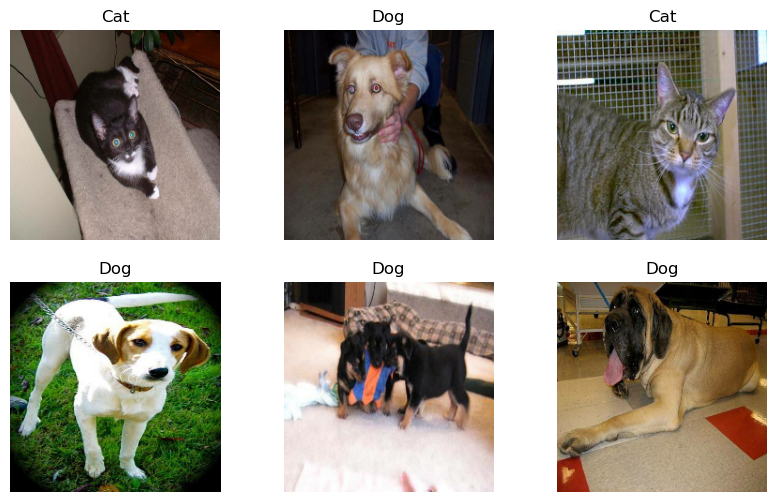

In [145]:
def show_images(dataset, num_images=6):
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            plt.subplot(2, 3, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.show()

print("imagenes de entrenamiento")
show_images(train_dataset)

In [146]:
# Preprocesamiento y aumento de datos
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomCrop(IMG_SIZE[0], IMG_SIZE[1])
])

In [147]:

def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

# Aplicar preprocesamiento y aumento de datos al conjunto de entrenamiento
train_dataset_augmented = train_dataset.map(lambda image, label: (data_augmentation(image), label))
train_dataset_augmented = train_dataset_augmented.map(preprocess_image)

train_dataset_preprocessed = train_dataset.map(preprocess_image)

In [148]:
# Concatenar los datos originales y aumentados
train_dataset = train_dataset_preprocessed.concatenate(train_dataset_augmented)
train_dataset = train_dataset.shuffle(1000).prefetch(tf.data.AUTOTUNE)

# Aplicar preprocesamiento y batching a los conjuntos de validación y prueba
val_dataset = val_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

In [150]:
# Cargar modelo base InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),
                                               include_top=False, weights="imagenet")

In [151]:
# Construir el modelo completo añadiendo capas adicionales al modelo base
model = tf.keras.Sequential([
    base_model,  # Modelo base MobileNetV2 sin las capas superiores
    tf.keras.layers.GlobalAveragePooling2D(),  # Capa de pooling global para reducir la dimensionalidad
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Capa de salida con 2
])


In [152]:
# Congelar las capas del modelo base
base_model.trainable = False

# Compilar el modelo especificando el optimizador, la función de pérdida y las métricas a evaluar
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [153]:
# Entrenar el modelo con las capas del modelo base congeladas (solo se entrenarán las capas añadidas)
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Loss en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7728 - loss: 0.4459 - val_accuracy: 0.9704 - val_loss: 0.0940
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9415 - loss: 0.1607 - val_accuracy: 0.9823 - val_loss: 0.0649
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9641 - loss: 0.1031 - val_accuracy: 0.9814 - val_loss: 0.0618
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9737 - loss: 0.0686 - val_accuracy: 0.9856 - val_loss: 0.0554
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9568 - loss: 0.1005 - val_accuracy: 0.9679 - val_loss: 0.0794
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 510ms/step - accuracy: 0.9745 - loss: 0.0702
Loss en el conjunto de prueba: 0.07209377735853195
Precisión en el conjunto de prueba: 0.9787060022354126


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


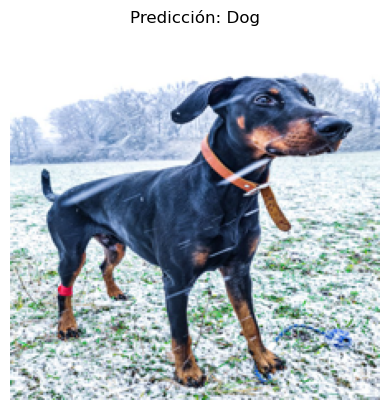

In [155]:
# Ruta de la imagen de perro
img_path = "/home/iabd/Escritorio/SAPA/SAPA/Examen2/Datos/rin.jpg"

# Cargar la imagen
img = Image.open(img_path)
img = img.resize(IMG_SIZE)
img_array = np.array(img)

# Aplicar preprocess_input del modelo correspondiente
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Añadir una dimensión de batch al tensor de la imagen
img_array = np.expand_dims(img_array, axis=0)

# Hacer la predicción
pred = model.predict(img_array)
predicted_class = class_names[np.argmax(pred)]

# Mostrar imagen con la predicción
plt.imshow(img)
plt.title(f"Predicción: {predicted_class}")
plt.axis("off")
plt.show()


## EJERCICIO 2

Tienes que detectar cuantos coches cruzan la línea. Tienes el video origen (trafico.mp4) así como el video de como quiero que quede (trafico_resultado.mp4), fíjate las etiquetas de los objetos y donde está la línea para contar los objetos.

Tienes que guardar en un archivo .mp4 el video que se crear y tienes que escribir en la terminal el marcador final.

In [ ]:
########## LAS CLASES ##########

from ultralytics.solutions.solutions import BaseSolution
from ultralytics.utils.plotting import Annotator, colors
import csv
from datetime import datetime
import os


class ObjectCounter(BaseSolution):
    """
    A class to manage the counting of objects in a real-time video stream based on their tracks.

    This class extends the BaseSolution class and provides functionality for counting objects moving in and out of a
    specified region in a video stream. It supports both polygonal and linear regions for counting.

    Attributes:
        in_count (int): Counter for objects moving inward.
        out_count (int): Counter for objects moving outward.
        counted_ids (List[int]): List of IDs of objects that have been counted.
        saved_ids (List[int]): List of IDs of objects that have been saved to the CSV file.
        classwise_counts (Dict[str, Dict[str, int]]): Dictionary for counts, categorized by object class.
        region_initialized (bool): Flag indicating whether the counting region has been initialized.
        show_in (bool): Flag to control display of inward count.
        show_out (bool): Flag to control display of outward count.
    """

    def __init__(self, **kwargs):
        """Initializes the ObjectCounter class for real-time object counting in video streams."""
        super().__init__(**kwargs)

        self.in_count = 0  # Contador para objetos que se acercan
        self.out_count = 0  # Contador para objetos que se alejan
        self.counted_ids = []  # Lista para IDs de los objetos ya contados
        self.saved_ids = []  # Lista de IDs ya guardados en el csv
        self.classwise_counts = {}  # Diccionario de conteo, categorizado
        self.region_initialized = False  # Booleno para inicialización de región

        self.show_in = self.CFG.get("show_in", True)
        self.show_out = self.CFG.get("show_out", True)

    def save_label_to_csv(self, track_id, label, action):
        """Save the label, track_id, action, and current time to a new CSV file with the current date."""
        if track_id in self.saved_ids:
            return  # Ignora guardar el ID si ya está en la lista

        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        current_date = datetime.now().strftime("%Y-%m-%d")  # Fecha actual en el formato correcto

        # Crea nombre del fichero con la fecha actual
        filename = f'tracked_objects_{current_date}.csv'

        # Comprueba que exista el fichero, si existe escribe otro nombre
        file_exists = os.path.isfile(filename)

        with open(filename, mode='a', newline='') as file:
            writer = csv.writer(file)

            # Si no existe el fichero escribe headers
            if not file_exists:
                writer.writerow(['track_id', 'label', 'action', 'date', 'time'])

            # Escribe en la columna de datos con el ID actual
            writer.writerow([track_id, label, action, current_time.split()[0], current_time.split()[1]])
            self.saved_ids.append(track_id)  # Marca el ID como guardado

    def count_objects(self, current_centroid, track_id, prev_position, cls):
        """
        Counts objects within a polygonal or linear region based on their tracks.

        Args:
            current_centroid (Tuple[float, float]): Current centroid values in the current frame.
            track_id (int): Unique identifier for the tracked object.
            prev_position (Tuple[float, float]): Last frame position coordinates (x, y) of the track.
            cls (int): Class index for classwise count updates.
        """
        if prev_position is None or track_id in self.counted_ids:
            return

        action = None  # Por defecto es None

        if len(self.region) == 2:  # Region lineal
            line = self.LineString(self.region)
            if line.intersects(self.LineString([prev_position, current_centroid])):
                if abs(self.region[0][0] - self.region[1][0]) < abs(self.region[0][1] - self.region[1][1]):
                    if current_centroid[0] > prev_position[0]:  # Movimiento derecha
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Movimiento izquierda
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                else:
                    if current_centroid[1] > prev_position[1]:  # Movimiento abajo
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Movimiento arriba
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                self.counted_ids.append(track_id)

        elif len(self.region) > 2:  # Region poligonal
            polygon = self.Polygon(self.region)
            if polygon.contains(self.Point(current_centroid)):
                region_width = max([p[0] for p in self.region]) - min([p[0] for p in self.region])
                region_height = max([p[1] for p in self.region]) - min([p[1] for p in self.region])

                if region_width < region_height:
                    if current_centroid[0] > prev_position[0]:  # Movimiento derecha
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Movimiento izquierda
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                else:
                    if current_centroid[1] > prev_position[1]:  # Movimiento abajo
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Movimiento arriba
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                self.counted_ids.append(track_id)

        # Guarda la etiqueta y la acción
        if action:
            label = f"{self.names[cls]} ID: {track_id}"
            self.save_label_to_csv(track_id, label, action)

    def store_classwise_counts(self, cls):
        """Initialize class-wise counts for a specific object class if not already present."""
        if self.names[cls] not in self.classwise_counts:
            self.classwise_counts[self.names[cls]] = {"IN": 0, "OUT": 0}

    def display_counts(self, im0):
        """Displays object counts on the input image or frame."""
        labels_dict = {
            str.capitalize(key): f"{'IN ' + str(value['IN']) if self.show_in else ''} "
            f"{'OUT ' + str(value['OUT']) if self.show_out else ''}".strip()
            for key, value in self.classwise_counts.items()
            if value["IN"] != 0 or value["OUT"] != 0
        }

        if labels_dict:
            self.annotator.display_analytics(im0, labels_dict, (104, 31, 17), (255, 255, 255), 10)

        for track_id in self.track_ids:
            if track_id in self.counted_ids:
                in_count = self.in_count
                label = f"ID:{track_id} count at number {in_count}"
                self.annotator.box_label(self.boxes[self.track_ids.index(track_id)], label=label, color=(255, 255, 0))

    def count(self, im0):
        """Processes input data (frames or object tracks) and updates object counts."""
        if not self.region_initialized:
            self.initialize_region()
            self.region_initialized = True

        self.annotator = Annotator(im0, line_width=self.line_width)
        self.extract_tracks(im0)
        self.annotator.draw_region(reg_pts=self.region, color=(104, 0, 123), thickness=self.line_width * 2)

        for box, track_id, cls in zip(self.boxes, self.track_ids, self.clss):
            self.store_tracking_history(track_id, box)
            self.store_classwise_counts(cls)

            label = f"{self.names[cls]} ID: {track_id}"
            self.annotator.box_label(box, label=label, color=colors(cls, True))

            current_centroid = ((box[0] + box[2]) / 2, (box[1] + box[3]) / 2)
            prev_position = self.track_history[track_id][-2] if len(self.track_history[track_id]) > 1 else None
            self.count_objects(current_centroid, track_id, prev_position, cls)

        self.display_counts(im0)
        self.display_output(im0)

        return im0

In [ ]:
# Función para el tracking del ratón
def RGB(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:  # Comprueba que se mueva el ratón
        point = [x, y]
        print(f"Mouse moved to: {point}")

# Abrir el video
cap = cv2.VideoCapture("/home/iabd/Escritorio/SAPA/SAPA/Examen2/trafico.mp4")

# Define región para contar
region_points = [(386, 103), (458, 499)]

# Inicializa el contador
counter = ObjectCounter(
    region=region_points,  # Pasar los puntos de la región
    model="Datos/yolo11s.pt",  # Modelo que cuente objetos
    classes=[2],  # Fijar la detección de clases a coches (clase 2 en COCO dataset)
    show_in=True,  # Enseñar contador de entradas
    show_out=True,  # Enseñar contador de salidas
    line_width=2,  # Ajustar ancho de línea para el output
)

# Crear una ventana con nombre y activar detección de ratón
cv2.namedWindow('RGB')
cv2.setMouseCallback('RGB', RGB)

# Obtener propiedades del video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Inicializar el escritor de video
out = cv2.VideoWriter("/home/iabd/Escritorio/SAPA/SAPA/Examen2/trafico_resultado.mp4", fourcc, fps, (frame_width, frame_height))

count = 0

while True:
    # Leer fotograma del video
    ret, frame = cap.read()
    if not ret:
        break

    count += 1
 
    frame = cv2.resize(frame, (frame_width, frame_height))

    # Procesar el fotograma con el contador de objetos
    with torch.no_grad():
        frame = counter.count(frame)

    # Escribir el fotograma procesado en el archivo de salida
    out.write(frame)

    # Enseñar el fotograma
    cv2.imshow("RGB", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):  # Pulsar q para salir
        break

# Liberar el capturador de video y cerrar la ventana
cap.release()
out.release()
cv2.destroyAllWindows()

# Imprimir el marcador final
print(f"Total de coches que cruzar la línea: {counter.in_count + counter.out_count}")

Ultralytics Solutions: ✅ {'region': [(386, 103), (458, 499)], 'show_in': True, 'show_out': True, 'colormap': None, 'up_angle': 145.0, 'down_angle': 90, 'kpts': [6, 8, 10], 'analytics_type': 'line', 'json_file': None, 'records': 5, 'model': 'Datos/yolo11s.pt', 'classes': [2], 'line_width': 2}

0: 320x640 14 cars, 4.7ms
Speed: 2.3ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 14 cars, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 14 cars, 4.9ms
Speed: 1.4ms preprocess, 4.9ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 14 cars, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 14 cars, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 14 cars, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 0.9ms postprocess per i

## EJERCICIO 3
A partir de los datos proporcionados:
* Crea dos conjuntos de datos: train y test
* Crea el modelo que tienes en la imagen modelo.png
* Muestra en una imagen el modelo creado.
* Entrena el modelo probando diferentes tasas de aprendizaje usando detención temprana y evalúa cada modelo en el conjunto de test (en el entrenamiento indica que tiene que coger el 5% para el conjunto de validación).
* Guarda el modelo cuya media de las métricas de las tres salidas en el conjunto de test sea la mejor.
* Indica cuál es la tasa de aprendizaje del modelo elegido.

In [63]:
# Generar datos artificiales
np.random.seed(42)
X = np.random.rand(5000, 15) * 15  # 5000 muestras con 15 características entre 0 y 15
X1 = X[:, :10]  # Primera entrada con 10 características
X2 = X[:, 5:]  # Segunda entrada con 10 características solapadas

# Agregar ruido aleatorio a Y
noise = np.random.normal(0, 0.1, (5000, 3))
Y1 = np.sin(np.sum(X1, axis=1)) + np.cos(np.sum(X2, axis=1)) + noise[:, 0]
Y2 = np.tanh(np.prod(X1, axis=1) * np.prod(X2, axis=1)) + noise[:, 1]
Y3 = np.log1p(np.mean(X1, axis=1) + np.mean(X2, axis=1)) + noise[:, 2]

In [64]:
tf.keras.backend.clear_session()

# Crear conjuntos de datos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, np.column_stack((Y1, Y2, Y3)), test_size=0.2, random_state=42)


In [65]:
# Definir entradas
input_dcha = tf.keras.layers.Input(shape=(10,), name="Input_Dcha")
input_izda = tf.keras.layers.Input(shape=(10,), name="Input_Izda")

In [66]:
# Rama centro
rama_ct_norm= tf.keras.layers.Normalization()(input_dcha)
rama_ct= tf.keras.layers.Dense(100, activation='relu')(rama_ct_norm)
rama_ct_dense= tf.keras.layers.Dense(100, activation='relu')(rama_ct)


In [67]:
# Rama derecha
rama_dc = tf.keras.layers.Dense(100, activation='relu')(rama_ct_norm)
rama_dc = tf.keras.layers.Dense(100, activation='relu')(rama_dc)
rama_dc = tf.keras.layers.Dense(100, activation='relu')(rama_dc)
rama_dc = tf.keras.layers.Dropout(0.5)(rama_dc)
rama_dc = tf.keras.layers.Concatenate()([rama_dc, rama_ct_dense])


In [68]:
# Rama izquierda

rama_iz = tf.keras.layers.Normalization()(input_izda)
rama_iz = tf.keras.layers.Dense(200, activation='relu')(rama_iz)
rama_iz = tf.keras.layers.Dense(200, activation='relu')(rama_iz)
rama_iz = tf.keras.layers.BatchNormalization()(rama_iz)
rama_iz = tf.keras.layers.Dense(100, activation='relu')(rama_iz)
rama_iz = tf.keras.layers.BatchNormalization()(rama_iz)
rama_iz = tf.keras.layers.Dense(100, activation='relu')(rama_iz)
rama_iz = tf.keras.layers.Concatenate()([rama_iz, rama_ct_dense])


In [69]:
salida_dcha = tf.keras.layers.Dense(1, name="salida_dcha")(rama_dc)
salida_centro = tf.keras.layers.Dense(1, name="salida_centro")(rama_ct_dense)
salida_izda = tf.keras.layers.Dense(1, name="salida_izda")(rama_iz)

In [70]:
# Definir modelo
model = tf.keras.Model(inputs=[input_dcha, input_izda], outputs=[salida_dcha, salida_centro, salida_izda])

# Resumen del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Izda          │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 10)        │         21 │ Input_Izda[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Dcha          │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 200)       │      2,200 │ normalization_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 10)        │         21 │ Input_Dcha[0][0]  │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 200)       │     40,200 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │      1,100 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200)       │        800 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 100)       │     10,100 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 100)       │     20,100 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │     10,100 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │      1,100 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     10,100 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 100)       │     10,100 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 200)       │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ salida_dcha (Dense) │ (None, 1)         │        201 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ salida_centro       │ (None, 1)         │        101 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 106,845 (417.37 KB)

 Trainable params: 106,203 (414.86 KB)

 Non-trainable params: 642 (2.52 KB)

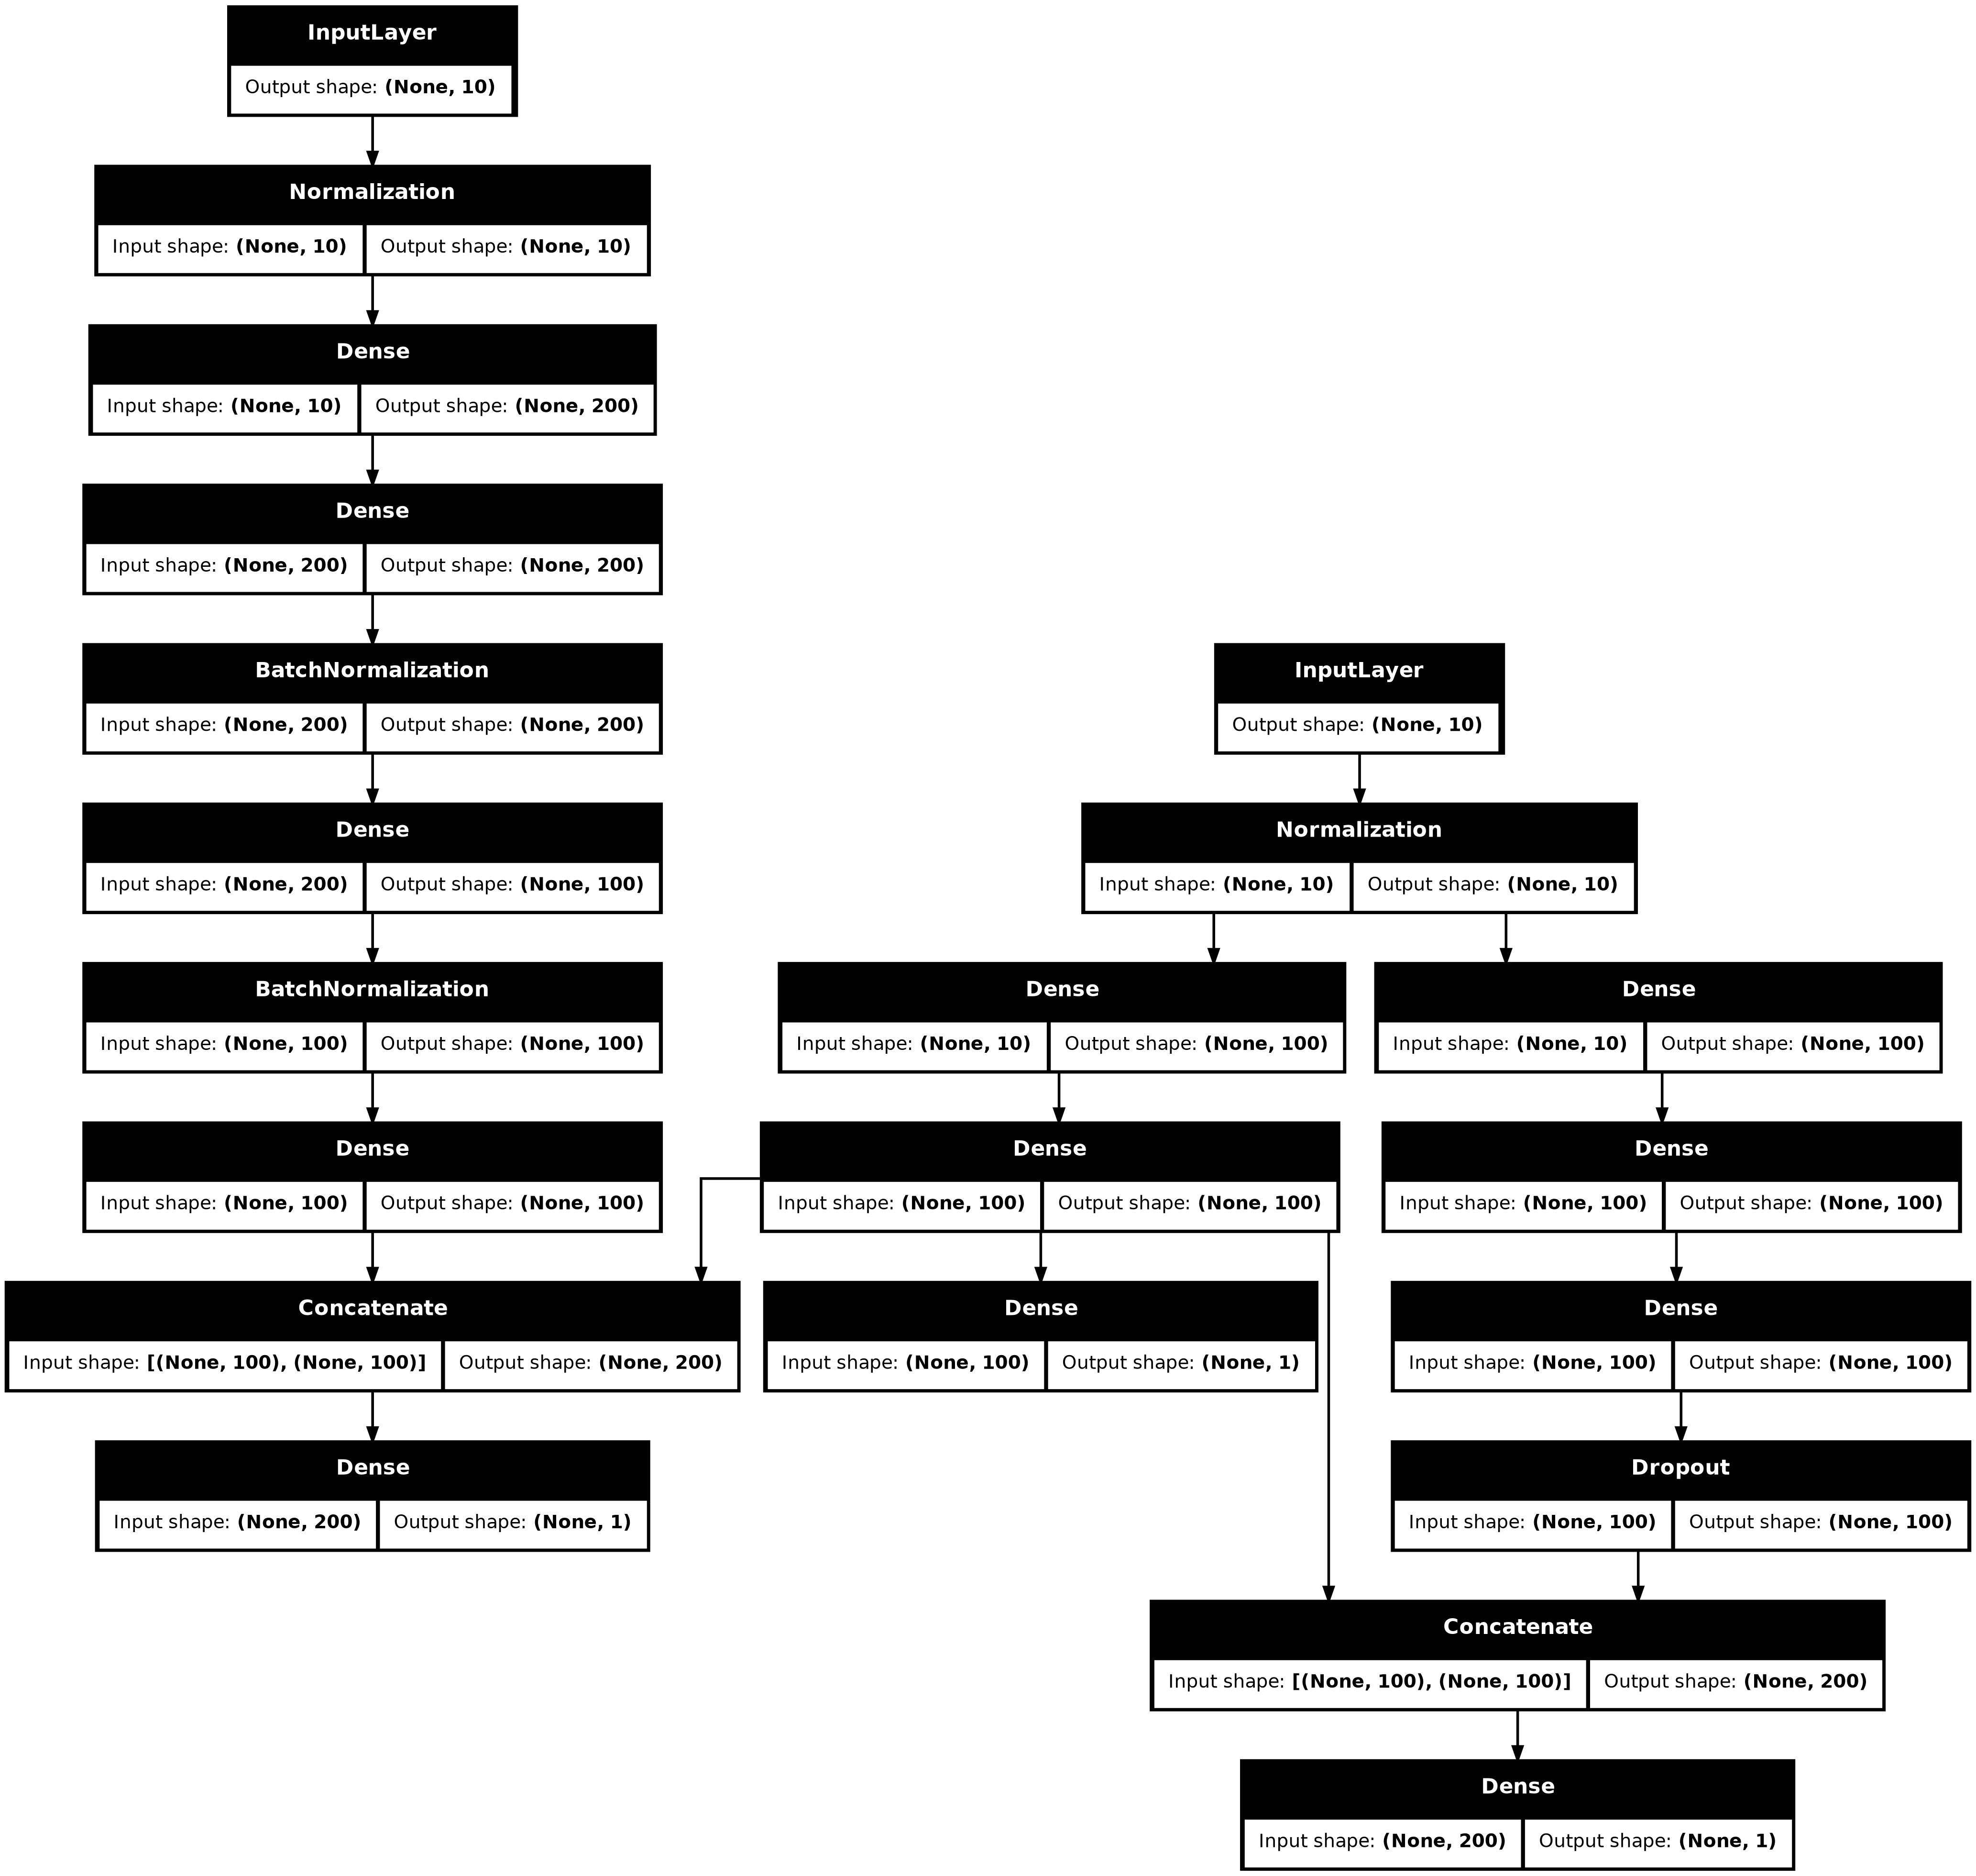

In [71]:
tf.keras.utils.plot_model(model, "modelo_irune.png", show_shapes=True)


In [73]:
# Definir diferentes tasas de aprendizaje para probar
learning_rates = [0.001, 0.0001, 0.00001]

# Definir la detención temprana
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Almacenar los resultados de cada modelo
results = {}
best_model = None
best_lr = None
best_avg_mae = float('inf')

for lr in learning_rates:
    print(f"Entrenando con tasa de aprendizaje: {lr}")
    
    # Crear una nueva instancia del modelo
    model = tf.keras.Model(inputs=[input_dcha, input_izda], outputs=[salida_dcha, salida_centro, salida_izda])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['mae', 'mae', 'mae'])
    
    # Entrenar el modelo
    history = model.fit(
        [X_train[:, :10], X_train[:, 5:]], [Y_train[:, 0], Y_train[:, 1], Y_train[:, 2]],
        validation_split=0.05,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluar el modelo en el conjunto de prueba
    test_loss, test_loss1, test_loss2, test_loss3, test_mae1, test_mae2, test_mae3 = model.evaluate([X_test[:, :10], X_test[:, 5:]], [Y_test[:, 0], Y_test[:, 1], Y_test[:, 2]])
    
    # Calcular la media de las métricas MAE
    avg_mae = (test_mae1 + test_mae2 + test_mae3) / 3
    
    # Almacenar los resultados
    results[lr] = {
        'history': history,
        'test_loss': test_loss,
        'test_mae1': test_mae1,
        'test_mae2': test_mae2,
        'test_mae3': test_mae3,
        'avg_mae': avg_mae
    }
    
    # Guardar el mejor modelo
    if avg_mae < best_avg_mae:
        best_avg_mae = avg_mae
        best_model = model
        best_lr = lr


Entrenando con tasa de aprendizaje: 0.001
Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0165 - salida_centro_loss: 0.0203 - salida_centro_mae: 0.1132 - salida_dcha_loss: 0.9726 - salida_dcha_mae: 0.8048 - salida_izda_loss: 0.0235 - salida_izda_mae: 0.1231 - val_loss: 1.2189 - val_salida_centro_loss: 0.0174 - val_salida_centro_mae: 0.1134 - val_salida_dcha_loss: 1.1079 - val_salida_dcha_mae: 0.8622 - val_salida_izda_loss: 0.0372 - val_salida_izda_mae: 0.1589
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9298 - salida_centro_loss: 0.0183 - salida_centro_mae: 0.1068 - salida_dcha_loss: 0.8891 - salida_dcha_mae: 0.7652 - salida_izda_loss: 0.0224 - salida_izda_mae: 0.1194 - val_loss: 1.2412 - val_salida_centro_loss: 0.0188 - val_salida_centro_mae: 0.1185 - val_salida_dcha_loss: 1.1057 - val_salida_dcha_mae: 0.8551 - val_salida_izda_loss: 0.0673 - val_salida_izda_mae: 0.2065
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9556 - salida_centro

In [74]:
# Guardar el mejor modelo
best_model.save('best_model.h5')

In [75]:
# Mostrar los resultados
for lr, result in results.items():
    print(f"Tasa de aprendizaje: {lr}")
    print(f"Loss en el conjunto de prueba: {result['test_loss']}")
    print(f"MAE en el conjunto de prueba (salida derecha): {result['test_mae1']}")
    print(f"MAE en el conjunto de prueba (salida centro): {result['test_mae2']}")
    print(f"MAE en el conjunto de prueba (salida izquierda): {result['test_mae3']}")
    print(f"Media de MAE: {result['avg_mae']}")
    print("\n")

print(f"La mejor tasa de aprendizaje es: {best_lr}")

Tasa de aprendizaje: 0.001
Loss en el conjunto de prueba: 1.2152864933013916
MAE en el conjunto de prueba (salida derecha): 0.09902139008045197
MAE en el conjunto de prueba (salida centro): 0.8886906504631042
MAE en el conjunto de prueba (salida izquierda): 0.10727506130933762
Media de MAE: 0.36499570061763126


Tasa de aprendizaje: 0.0001
Loss en el conjunto de prueba: 1.2215312719345093
MAE en el conjunto de prueba (salida derecha): 0.09482824802398682
MAE en el conjunto de prueba (salida centro): 0.8904529213905334
MAE en el conjunto de prueba (salida izquierda): 0.09825581312179565
Media de MAE: 0.361178994178772


Tasa de aprendizaje: 1e-05
Loss en el conjunto de prueba: 1.2213290929794312
MAE en el conjunto de prueba (salida derecha): 0.09454017877578735
MAE en el conjunto de prueba (salida centro): 0.8902690410614014
MAE en el conjunto de prueba (salida izquierda): 0.09758424013853073
Media de MAE: 0.36079781999190647


La mejor tasa de aprendizaje es: 1e-05
